In [66]:
#ライブラリをインポート
import os #OSに依存する様々な機能を利用するためのモジュール(ファイルやディレクトリ操作など)
import re #正規表現を利用するためのモジュール
import csv  #csvファイルを扱うためのモジュール
import math #数学的計算のためのモジュール
from decimal import Decimal #小数点桁落ちをなくすためのモジュール
import matplotlib.pyplot as plt #グラフ描画のためのモジュール
import numpy as np  #多次元配列計算のためのモジュール
import pandas as pd #データフレームを扱うためのモジュール
from scipy import signal  #信号処理のためのモジュール
from scipy.stats import skew, kurtosis  #歪度と尖度を調べるためのモジュール
from sklearn.model_selection import train_test_split  #データをトレーニング用とテスト用に分けるためのモジュール
from sklearn import preprocessing #データを正規化するためのモジュール
from sklearn.preprocessing import StandardScaler  #データを標準化するためのモジュール
from sklearn.preprocessing import LabelEncoder  #カテゴリ変数を数値化するためのモジュール
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score #機械学習モデルの性能評価のためのモジュール
import tensorflow as tf #TensorFlow(Googleが開発したオープンソースの機械学習フレームワーク)
from tensorflow import keras  #TensorFlow用のニューラルネットワークライブラリAPI
from tensorflow.keras import layers #ニューラルネットワークのレイヤーを定義するためのモジュール

In [67]:
#Google colab用
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
#GPUを使うためのコマンド
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
#よく使うgit command

#google colabと揃える
#git fetch origin main
#git reset --hard origin/main

In [69]:
#定数を定義
BINS = 200  #ヒストグラムのビンの数
EPSILON = .00001  #スムージングパラメータ
UPPER_LIMIT = 1.1 #静止区間の上限
LOWER_LIMIT = 0.9 #静止区間の加減
STATIONARY_INTERVALS = 5  #静止区間除去のサンプルの間隔(静止区間が何サンプル連続したら除去するか)
TRAIN_SIZE = 0.8  #機械学習のトレーニングデータの割合

#transformer regression
#各種パラメータ
NUM_HEADS = 2
KEY_DIM = 100
DROPOUT = 0.1
N = 1 #Encoderのレイヤー

In [70]:
#Hascの加速度データのCSVファイルから3軸加速度を取得する関数
def get_acceleration(filename: str) -> tuple[list[float], list[float], list[float]]:
    AccX, AccY, AccZ = [], [], []
    with open(filename) as f:
        reader = csv.reader(f)
        for row in reader:
            AccX.append(float(row[1]))
            AccY.append(float(row[2]))
            AccZ.append(float(row[3]))

    return AccX, AccY, AccZ

In [71]:
#加速度データのCSVファイルから3軸加速度を取得する関数
def get_acceleration2(filename: str) -> tuple[list[float], list[float], list[float]]:
    AccX, AccY, AccZ = [], [], []
    with open(filename) as f:
        reader = csv.reader(f)
        for row in reader:
            AccX.append(float(row[2]))
            AccY.append(float(row[3]))
            AccZ.append(float(row[4]))

    return AccX, AccY, AccZ

In [72]:
#3軸合成加速度を計算する関数
def acc_to_resultant(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める
    return ResultantAcc

In [73]:
#静止区間を除去する関数(STATIONARY_INTERVALS分のみ)
def acc_to_remove_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
            if counter == STATIONARY_INTERVALS: #カウントがSTATIONARY_INTERVALSに達したらその区間を削除
                del ResultantAcc[i+1-STATIONARY_INTERVALS:i+1]    #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
        else:
            counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [74]:
#静止区間を除去する関数(STATIONARY_INTERVALS以上続いた静止区間全て)
def acc_to_remove_all_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
        else:
            if counter >= STATIONARY_INTERVALS:
                del ResultantAcc[i+1-counter:i+1]   #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
            else :
                counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [75]:
#連続する2サンプルの差分を取る関数
def calculate_differences_of_acceleration(ResultantAcc: list[float]) -> list[float]:
    DifferenceAcc = [math.fabs(Decimal(ResultantAcc[i + 1]) - Decimal(ResultantAcc[i])) for i in range(len(ResultantAcc) - 1)]  #連続する2サンプルの誤差を取る
    return DifferenceAcc

In [76]:
#入力された加速度の差分のリストからヒストグラムを作る関数（ビンの範囲が各加速度の差分データの最小値〜最大値）
def create_histogram(DifferenceAcc_list: list[float]) -> np.histogram:
    DifferenceAcc_hist = np.zeros((len(DifferenceAcc_list), BINS), dtype=float)
    for i in range(len(DifferenceAcc_list)):
        min_value = min(DifferenceAcc_list[i])
        max_value = max(DifferenceAcc_list[i])
        #DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, range=(min_value, max_value)) #ヒストグラムを作成し、同じ数のビンで区切る
        DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, density=True) #ヒストグラムを作成し、同じ数のビンで区切る
    return DifferenceAcc_hist

In [77]:
#各加速度データをダウンサンプリングする関数
def resampling_Acc(originHz: int, newHz: int, AccX: list[float], AccY: list[float], AccZ: list[float], Hz: np.array) -> tuple[list[float], list[float], list[float], np.array]:
    i = 0   #カウンター変数

    while (Hz[i] == originHz):
        originlen = len(AccX[i])    #元々のデータの長さ
        sampling_factor = int(originlen * (newHz/originHz)) #ダウンサンプリングした後のデータの長さ
        newAccX = signal.resample(AccX[i], sampling_factor)    #データをダウンサンプリング
        newAccY = signal.resample(AccY[i], sampling_factor)    #データをダウンサンプリング
        newAccZ = signal.resample(AccZ[i], sampling_factor)    #データをダウンサンプリング
        AccX.append(newAccX)   #ダウンサンプリングデータを加速度データに追加
        AccY.append(newAccY)   #ダウンサンプリングデータを加速度データに追加
        AccZ.append(newAccZ)   #ダウンサンプリングデータを加速度データに追加
        Hz = np.append(Hz, newHz)   #ダウンサンプリングレートを追加
        i += 1

    return AccX, AccY, AccZ, Hz

In [78]:
#My Transformer Model
def Transformer_Encoder():
      # Define the input shape
      input_shape = (BINS,)
      output_shape = (1,)

      #形を定義(このモジュールは行列でないとダメっぽい)
      inputs_encoder = layers.Input(shape=input_shape)
      #inputs_decoder = layers.Input(shape=output_shape)

      #Encoderに対する入力の形状
      x_encoder = layers.Reshape((1, 200))(inputs_encoder)

      #Transformer Encoder Layer(BERT)
      for i in range(N):
            #Multi-Head-Attention Layer
            attention_encoder = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, use_bias=True)(x_encoder, x_encoder, x_encoder)

            #Dropout Layer
            attention_encoder = layers.Dropout(rate=DROPOUT)(attention_encoder)
            #Add & Norm Layer
            attention_encoder = layers.LayerNormalization()(x_encoder + attention_encoder)

            #Feed-Forward-Network
            ffn_encoder = layers.Dense(BINS * 4, use_bias=True, activation="relu")(attention_encoder)
            ffn_encoder = layers.Dense(BINS, use_bias=True)(ffn_encoder)

            #Dropout Layer
            ffn_encoder = layers.Dropout(rate=DROPOUT)(ffn_encoder)
            #Add & Norm Layer
            x_encoder = layers.LayerNormalization()(attention_encoder + ffn_encoder)

      x = layers.Flatten()(x_encoder)
      x = layers.Dense(32, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      x = layers.Dense(16, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      outputs = layers.Dense(1, activation="relu")(x)

      model = keras.Model(inputs=inputs_encoder, outputs=outputs)

      # Compile the model
      model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.mean_squared_error,
            metrics=[keras.metrics.mean_squared_error],
      )

      return model

In [79]:
#path(サンプリング周波数100Hzのデータ)から加速度の差分値, ヒストグラム, 正解ラベルを返す関数
def path_to_histogram(path: str) -> tuple[list[float], np.array, np.array]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    #使う変数を宣言
    readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み二次元配列に格納
    for i in filename:
        readAccX, readAccY, readAccZ = get_acceleration(path+i)
        AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

    Hz = np.ones(len(filename)) * 100

    #各加速度データをダウンサンプリング
    for i in range(9, 1, -1):
        AccX, AccY, AccZ, Hz = resampling_Acc(100, i * 10, AccX, AccY, AccZ, Hz)

    #静止区間を除去
    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

    #ヒストグラム作成
    for i in range(len(ResultantAcc)):
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
    DifferenceAcc_hist = create_histogram(DifferenceAcc_list)

    return DifferenceAcc_list, DifferenceAcc_hist, Hz

In [16]:
#path(サンプリング周波数100Hzのデータ)から様々な特徴量と正解ラベルを返す関数
def path_to_features(path: str) -> tuple[np.array, np.array]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    #使う変数を宣言
    readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み二次元配列に格納
    for i in filename:
        readAccX, readAccY, readAccZ = get_acceleration(path+i)
        AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

    Hz = np.ones(len(filename)) * 100

    #各加速度データをダウンサンプリング
    for i in range(9, 1, -1):
        AccX, AccY, AccZ, Hz = resampling_Acc(100, i * 10, AccX, AccY, AccZ, Hz)

    features = np.ones((len(Hz), 6))    #各特徴量を入れる変数でこの関数の返り値

    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_resultant(AccX[i], AccY[i], AccZ[i]))
        features[i][0] = np.var(ResultantAcc[i])   #静止区間を除去する前の合成加速度の分散値を0列目に格納

    #静止区間を除去
    ResultantAcc = []
    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

    for i in range(len(Hz)):
      features[i][1] = np.var(ResultantAcc[i])   #静止区間を除去した後の合成加速度の分散値を1列目に格納

    #ヒストグラム作成
    for i in range(len(ResultantAcc)):
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
    DifferenceAcc_hist = create_histogram(DifferenceAcc_list)


    for i in range(len(Hz)):
      features[i][2] = kurtosis(DifferenceAcc_hist[i])  #標準化前のヒストグラムの尖度を2列目に格納
      features[i][3] = skew(DifferenceAcc_hist[i])  #標準化前のヒストグラムの歪度を3列目に格納

    #標準化
    scaler = StandardScaler()
    # Fit the scaler to x_train
    scaler.fit(DifferenceAcc_hist)
    # Use the scaler to transform x_train and x_test
    DifferenceAcc_hist = scaler.transform(DifferenceAcc_hist)

    for i in range(len(Hz)):
      features[i][4] = kurtosis(DifferenceAcc_hist[i])  #標準化後のヒストグラムの尖度を4列目に格納
      features[i][5] = skew(DifferenceAcc_hist[i])  #標準化後のヒストグラムの歪度を5列目に格納

    return features, Hz

In [106]:
DiffereneAcc_listWalk, DifferenceAcc_histWalk, HzWalk = path_to_histogram("/content/drive/MyDrive/hasc(walk)/")

In [107]:
DiffereneAcc_listKWalk, DifferenceAcc_histKWalk, HzKWalk = path_to_histogram("/content/drive/MyDrive/kuhar(walk)/")

In [84]:
DiffereneAcc_listSWalk, DifferenceAcc_histSWalk, HzSWalk = path_to_histogram("/content/drive/MyDrive/setback(walk)/")

In [108]:
std = StandardScaler()
DifferenceAcc_histWalk = std.fit_transform(DifferenceAcc_histWalk)

In [109]:
std = StandardScaler()
DifferenceAcc_histKWalk = std.fit_transform(DifferenceAcc_histKWalk)

In [110]:
DifferenceAcc_hist = np.concatenate([DifferenceAcc_histWalk, DifferenceAcc_histKWalk])

In [111]:
Hz = np.concatenate([HzWalk, HzKWalk])

In [115]:
mae

[19.185897435897434,
 20.136752136752136,
 16.767094017094017,
 16.884615384615383,
 12.50531914893617,
 11.456018518518519,
 11.333333333333334,
 12.685185185185185,
 13.761316872427983,
 9.842592592592593]

In [116]:
y_test = y_test.reshape(len(y_test), 1)

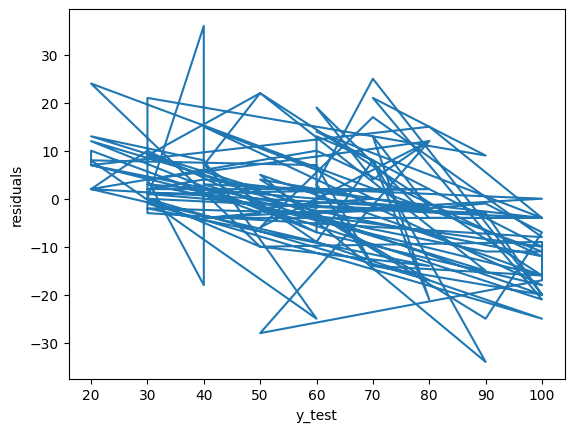

In [117]:
residuals = y_pred - y_test

# 残差をプロットします。
plt.plot(y_test, residuals)
plt.xlabel("y_test")
plt.ylabel("residuals")
plt.show()

In [118]:
residuals

<tf.Tensor: shape=(108, 1), dtype=int32, numpy=
array([[  2],
       [ 13],
       [  8],
       [-25],
       [  8],
       [  7],
       [-14],
       [  3],
       [ 25],
       [-20],
       [-14],
       [-16],
       [  7],
       [ 10],
       [ -3],
       [ -3],
       [ -4],
       [ -4],
       [  0],
       [ 36],
       [-18],
       [  4],
       [ 12],
       [ -6],
       [ 17],
       [ -8],
       [ -3],
       [ -1],
       [-25],
       [ -9],
       [  2],
       [ 10],
       [ -7],
       [ 12],
       [ -2],
       [ 13],
       [  8],
       [-21],
       [ 13],
       [ -2],
       [  4],
       [-25],
       [ -7],
       [ -1],
       [ -2],
       [  2],
       [ 10],
       [-12],
       [  7],
       [  7],
       [ 15],
       [ -4],
       [ -4],
       [ 19],
       [  4],
       [ 12],
       [-28],
       [-17],
       [ -9],
       [-10],
       [-14],
       [ -2],
       [ -3],
       [-17],
       [  0],
       [-10],
       [ 24],
       [-11],


In [112]:
len(Hz)

2160

In [113]:
X_train, X_test, y_train, y_test = train_test_split(DifferenceAcc_hist,  Hz, test_size = 0.05)
model = Transformer_Encoder()
history = model.fit(X_train, y_train, batch_size=32, epochs=500, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(X_test), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, y_test))

Epoch 1/500
52/52 [==============================] - 5s 15ms/step - loss: 1954.9724 - mean_squared_error: 1954.9724 - val_loss: 664.1223 - val_mean_squared_error: 664.1223
Epoch 2/500
52/52 [==============================] - 0s 9ms/step - loss: 518.6043 - mean_squared_error: 518.6043 - val_loss: 325.1460 - val_mean_squared_error: 325.1460
Epoch 3/500
52/52 [==============================] - 0s 9ms/step - loss: 400.9338 - mean_squared_error: 400.9338 - val_loss: 269.1100 - val_mean_squared_error: 269.1100
Epoch 4/500
52/52 [==============================] - 1s 11ms/step - loss: 317.2947 - mean_squared_error: 317.2947 - val_loss: 233.1353 - val_mean_squared_error: 233.1353
Epoch 5/500
52/52 [==============================] - 1s 16ms/step - loss: 300.9182 - mean_squared_error: 300.9182 - val_loss: 231.3520 - val_mean_squared_error: 231.3520
Epoch 6/500
52/52 [==============================] - 1s 16ms/step - loss: 283.4958 - mean_squared_error: 283.4958 - val_loss: 226.2836 - val_mean_squa

In [114]:
plt.plot(range(1, 500+1), history.history['accuracy'], "-o")
plt.plot(range(1, 500+1), history.history['val_acc'], "-o")
plt.title('model accuracy')
plt.ylabel('accuracy')  # Y軸ラベル
plt.xlabel('epoch')  # X軸ラベル
plt.grid()
plt.legend(['acc', 'val_acc'], loc='best')
plt.show()

KeyError: ignored

In [ ]:
len(HzHasc)

936

In [36]:
mae

[19.185897435897434,
 20.136752136752136,
 16.767094017094017,
 16.884615384615383,
 12.50531914893617]

In [32]:
model = Transformer_Encoder()
model.fit(DifferenceAcc_histWalk, HzWalk, batch_size=32, epochs=50, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(DifferenceAcc_histJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzJog))
mae

Epoch 1/50
12/12 [==============================] - 5s 40ms/step - loss: 3976.0037 - mean_squared_error: 3976.0037 - val_loss: 112.8734 - val_mean_squared_error: 112.8734
Epoch 2/50
12/12 [==============================] - 0s 13ms/step - loss: 2795.3359 - mean_squared_error: 2795.3359 - val_loss: 27.1650 - val_mean_squared_error: 27.1650
Epoch 3/50
12/12 [==============================] - 0s 11ms/step - loss: 1826.8389 - mean_squared_error: 1826.8389 - val_loss: 438.1408 - val_mean_squared_error: 438.1408
Epoch 4/50
12/12 [==============================] - 0s 13ms/step - loss: 876.1071 - mean_squared_error: 876.1071 - val_loss: 1638.7201 - val_mean_squared_error: 1638.7201
Epoch 5/50
12/12 [==============================] - 0s 13ms/step - loss: 583.4191 - mean_squared_error: 583.4191 - val_loss: 2495.4875 - val_mean_squared_error: 2495.4875
Epoch 6/50
12/12 [==============================] - 0s 11ms/step - loss: 575.9836 - mean_squared_error: 575.9836 - val_loss: 2022.2009 - val_mean_s

[19.185897435897434,
 20.136752136752136,
 16.767094017094017,
 16.884615384615383]

In [132]:
for i in range(5):
  X_train, X_test, y_train, y_test = train_test_split(DifferenceAcc_hist,  Hz, test_size = 0.2)
  model = Transformer_Encoder()
  model.fit(X_train, y_train, batch_size=64, epochs=300, shuffle=True, validation_split=0.2)
  model.fit(X_train, y_train, batch_size=32, epochs=300, shuffle=True, validation_split=0.2)
  model.fit(X_train, y_train, batch_size=32, epochs=300, shuffle=True, validation_split=0.2)
  y_pred = tf.cast(tf.clip_by_value(model.predict(X_test), 20, 100), tf.int32)
  mae.append(mean_absolute_error(y_pred, y_test))

ストリーミング出力は最後の 5000 行に切り捨てられました。
Epoch 203/300
5/5 [==============================] - 0s 45ms/step - loss: 76.0908 - mean_squared_error: 76.0908 - val_loss: 323.1563 - val_mean_squared_error: 323.1563
Epoch 204/300
5/5 [==============================] - 0s 38ms/step - loss: 102.1126 - mean_squared_error: 102.1126 - val_loss: 342.2716 - val_mean_squared_error: 342.2716
Epoch 205/300
5/5 [==============================] - 0s 31ms/step - loss: 87.1109 - mean_squared_error: 87.1109 - val_loss: 318.3011 - val_mean_squared_error: 318.3011
Epoch 206/300
5/5 [==============================] - 0s 33ms/step - loss: 94.5153 - mean_squared_error: 94.5153 - val_loss: 288.9337 - val_mean_squared_error: 288.9337
Epoch 207/300
5/5 [==============================] - 0s 37ms/step - loss: 106.1228 - mean_squared_error: 106.1228 - val_loss: 381.8158 - val_mean_squared_error: 381.8158
Epoch 208/300
5/5 [==============================] - 0s 31ms/step - loss: 106.6273 - mean_squared_error: 106.6273 - val_loss

In [133]:
mae

[14.22340425531915,
 13.159574468085106,
 13.574468085106384,
 16.0531914893617,
 11.319148936170214,
 7.542553191489362,
 5.9361702127659575,
 7.361702127659575,
 6.170212765957447,
 7.414893617021277]

In [34]:
len(HzHasc)

468

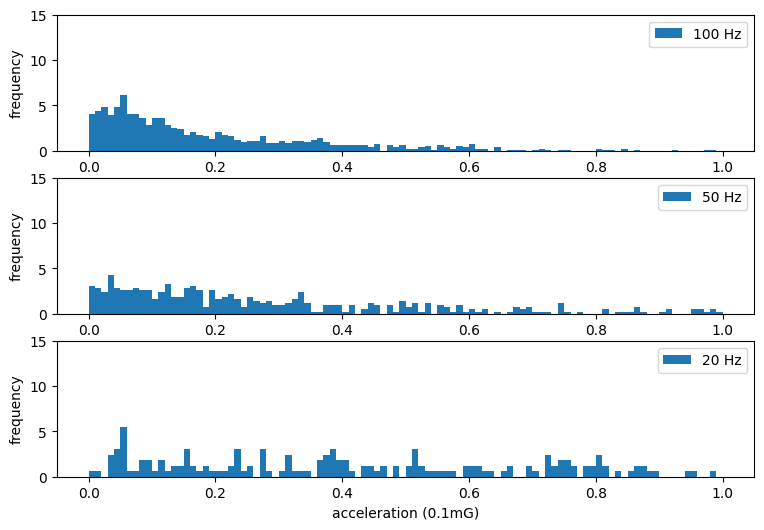

In [25]:
#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (9,6))
xl1 = "acceleration (0.1mG)"
yl1 = "frequency"

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す(範囲指定)
ax1.hist(DifferenceAcc_list[4], bins=100,density=True, range=(0, 1), label="100 Hz")
ax2.hist(DifferenceAcc_list[264], bins=100,density=True, range=(0, 1), label="50 Hz")
ax3.hist(DifferenceAcc_list[420], bins=100,density=True, range=(0, 1), label="20 Hz")

#各subplot領域にデータを渡す
#ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, label="100 Hz")
#ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, label="50 Hz")
#ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, label="20 Hz")

#各subplotにxラベルを追加
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl1)
ax3.set_xlabel(xl1)

#各subplotにyラベルを追加
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl1)
ax3.set_ylabel(yl1)

#各subplotのy軸の範囲を指定
ax1.set_ylim(0, 15)
ax2.set_ylim(0, 15)
ax3.set_ylim(0, 15)

# 凡例表示
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper right')

plt.show()

In [83]:
FeaturesHascWalk, HzHascWalk = path_to_features("/content/drive/MyDrive/hasc(walk)/")

In [43]:
len(HzHascWalk)

468

In [48]:
len(FeaturesHascWalk[:, 0])

468

In [84]:
skew(DifferenceAcc_histHasc[0])

1.5167658322798636

In [86]:
FeaturesHascWalk[0:52, 3]

array([ 1.51676583,  2.11909217,  2.21640096,  8.85583981,  2.39826452,
       13.85067319,  6.52092043,  1.43709034,  2.46155103,  1.31963691,
        2.33693797, 14.01601987,  6.26096139, 13.96253545,  1.96807214,
       14.01696687,  2.14760143,  3.57022031,  1.2797818 ,  1.32931708,
        1.15784772,  7.41907085,  2.24209284,  1.42984621,  8.49536724,
        3.19327773,  4.32477566,  3.02580923,  4.5900556 ,  4.18051062,
        3.87695507,  3.86979489,  3.94957944,  2.37174644,  4.0145332 ,
        9.26987765,  4.01034872,  3.49440751,  4.16348709,  3.2517354 ,
        2.47247776,  3.76863447,  2.68269049,  2.2735599 ,  2.30070189,
        3.01474208,  3.11598231,  3.07081522,  3.02440253,  3.4744331 ,
        2.91230244,  3.31349467])

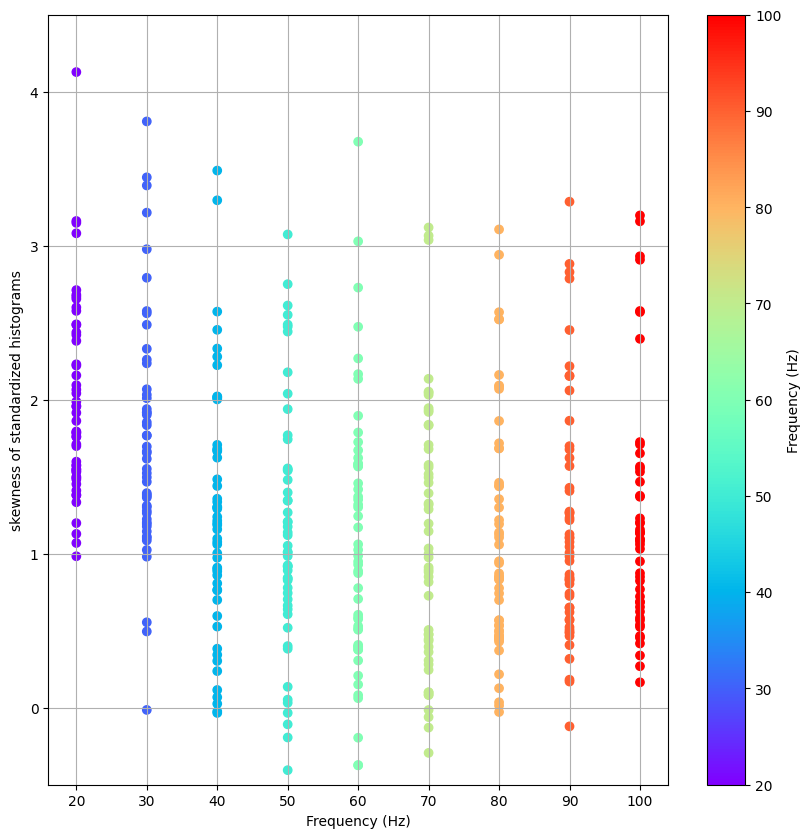

In [108]:
import numpy as np
import matplotlib.pyplot as plt
# クラスごとに色分けされたプロットを作成
plt.figure(figsize=(10, 10))
plt.scatter(HzHascWalk, FeaturesHascWalk[:, 5], c=HzHascWalk, cmap='rainbow', marker='o')
plt.colorbar(label='Frequency (Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('skewness of standardized histograms')
plt.ylim(-0.5, 4.5)
plt.grid(True)
plt.show()


In [32]:
skew(DifferenceAcc_list[420])

0.692346410924036

In [ ]:
pathHascJog = "/content/drive/MyDrive/hasc(jog)/"
filename = os.listdir(pathHascJog) #引数のパスのディレクトリの中のファイル名一覧を取得
#filename.remove(".DS_Store")

In [ ]:
#使う変数を宣言
readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
AccX, AccY, AccZ = [], [], []
ResultantAcc = []
DifferenceAcc_list = []

#各データセットからデータを読み込み二次元配列に格納
for i in filename:
    readAccX, readAccY, readAccZ = get_acceleration(pathHascJog+i)
    AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

HzHascJog = np.ones(len(filename)) * 100

#各加速度データをダウンサンプリング
for i in range(9, 1, -1):
    AccX, AccY, AccZ, HzHascJog = resampling_Acc(100, i * 10, AccX, AccY, AccZ, HzHascJog)

#静止区間を除去
for i in range(len(HzHascJog)):
    ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

#ヒストグラム作成
for i in range(len(ResultantAcc)):
    DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
DifferenceAcc_histHascJog = create_histogram(DifferenceAcc_list)

In [ ]:
#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (9,6))
xl1 = "acceleration (0.1mG)"
yl1 = "frequency"

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す(範囲指定)
ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, range=(0, 1), label="100 Hz")
ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, range=(0, 1), label="50 Hz")
ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, range=(0, 1), label="20 Hz")

#各subplot領域にデータを渡す
#ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, label="100 Hz")
#ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, label="50 Hz")
#ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, label="20 Hz")

#各subplotにxラベルを追加
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl1)
ax3.set_xlabel(xl1)

#各subplotにyラベルを追加
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl1)
ax3.set_ylabel(yl1)

#各subplotのy軸の範囲を指定
ax1.set_ylim(0, 15)
ax2.set_ylim(0, 15)
ax3.set_ylim(0, 15)

# 凡例表示
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper right')

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(DifferenceAcc_histHasc,  HzHasc, test_size = 0.2, random_state=123)

In [ ]:
HistHascJog, HzHascJog = path_to_histogram("/content/drive/MyDrive/hasc(jog)/")

In [ ]:
HistHascSkip, HzHascSkip = path_to_histogram("/content/drive/MyDrive/hasc(skip)/")

In [ ]:
HistHascSequence, HzHascSequence = path_to_histogram("/content/drive/MyDrive/hasc(sequence)/")

In [ ]:
HistHascWalk, HzHascWalk = path_to_histogram("/content/drive/MyDrive/hasc(walk)/")

In [ ]:
HistHascJog, HzHascJog = path_to_histogram("/content/drive/MyDrive/hasc(jog)/")

In [ ]:
HistKuharWalk, HzKuharWalk = path_to_histogram("/content/drive/MyDrive/kuhar(walk)/")

In [ ]:
HistKuharRun, HzKuharRun = path_to_histogram("/content/drive/MyDrive/kuhar(run)/")

In [ ]:
#HascWalkで構築→HascJogで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

In [ ]:
#HascWalkで構築→KuharWalkで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharWalk))
mse.append(mean_squared_error(y_pred, HzKuharWalk))
r2.append(r2_score(y_pred, HzKuharWalk))

In [ ]:
#HascWalkで構築→KuharRunで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharRun), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharRun))
mse.append(mean_squared_error(y_pred, HzKuharRun))
r2.append(r2_score(y_pred, HzKuharRun))

In [ ]:
#HascJogで構築→HascWalkで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

In [ ]:
#HascJogで構築→KuharWalkで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharWalk))
mse.append(mean_squared_error(y_pred, HzKuharWalk))
r2.append(r2_score(y_pred, HzKuharWalk))

In [ ]:
#HascJogで構築→KuharRunで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharRun), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharRun))
mse.append(mean_squared_error(y_pred, HzKuharRun))
r2.append(r2_score(y_pred, HzKuharRun))

In [ ]:
#KuharWalkで構築→HascWalkで試す
history = model.fit(HistKuharWalk, HzKuharWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

In [ ]:
#KuharWalkで構築→HascJogで試す
history = model.fit(HistKuharWalk, HzKuharWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

In [ ]:
#KuharWalkで構築→KuharRunで試す
history = model.fit(HistKuharWalk, HzKuharWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharRun), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharRun))
mse.append(mean_squared_error(y_pred, HzKuharRun))
r2.append(r2_score(y_pred, HzKuharRun))

In [ ]:
#KuharRunで構築→HascWalkで試す
history = model.fit(HistKuharRun, HzKuharRun, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

In [ ]:
#KuharRunで構築→HascJogで試す
history = model.fit(HistKuharRun, HzKuharRun, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

In [ ]:
#KuharRunで構築→KuharWalkで試す
history = model.fit(HistKuharRun, HzKuharRun, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistKuharWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzKuharWalk))
mse.append(mean_squared_error(y_pred, HzKuharWalk))
r2.append(r2_score(y_pred, HzKuharWalk))

In [ ]:
#HascWalkで構築→HascSkipで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSkip), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSkip))
mse.append(mean_squared_error(y_pred, HzHascSkip))
r2.append(r2_score(y_pred, HzHascSkip))

In [ ]:
#HascWalkで構築→HascSequenceで試す
history = model.fit(HistHascWalk, HzHascWalk, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSequence), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSequence))
mse.append(mean_squared_error(y_pred, HzHascSequence))
r2.append(r2_score(y_pred, HzHascSequence))

In [ ]:
#HascJogで構築→HascWalkで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

In [ ]:
#HascJogで構築→HascSkipで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSkip), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSkip))
mse.append(mean_squared_error(y_pred, HzHascSkip))
r2.append(r2_score(y_pred, HzHascSkip))

In [ ]:
#HascJogで構築→HascSequenceで試す
history = model.fit(HistHascJog, HzHascJog, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSequence), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSequence))
mse.append(mean_squared_error(y_pred, HzHascSequence))
r2.append(r2_score(y_pred, HzHascSequence))

In [ ]:
#HascSkipで構築→HascWalkで試す
history = model.fit(HistHascSkip, HzHascSkip, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

In [ ]:
#HascSkipで構築→HascJogで試す
history = model.fit(HistHascSkip, HzHascSkip, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

In [ ]:
#HascSkipで構築→HascSequenceで試す
history = model.fit(HistHascSkip, HzHascSkip, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSequence), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSequence))
mse.append(mean_squared_error(y_pred, HzHascSequence))
r2.append(r2_score(y_pred, HzHascSequence))

In [ ]:
#HascSequenceで構築→HascWalkで試す
history = model.fit(HistHascSequence, HzHascSequence, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascWalk), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascWalk))
mse.append(mean_squared_error(y_pred, HzHascWalk))
r2.append(r2_score(y_pred, HzHascWalk))

In [ ]:
#HascSequenceで構築→HascJogで試す
history = model.fit(HistHascSequence, HzHascSequence, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascJog), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascJog))
mse.append(mean_squared_error(y_pred, HzHascJog))
r2.append(r2_score(y_pred, HzHascJog))

In [ ]:
#HascSequenceで構築→HascSkipで試す
history = model.fit(HistHascSequence, HzHascSequence, batch_size=32, epochs=EPOCHS, shuffle=True, validation_split=0.2)
y_pred = tf.cast(tf.clip_by_value(model.predict(HistHascSkip), 20, 100), tf.int32)
mae.append(mean_absolute_error(y_pred, HzHascSkip))
mse.append(mean_squared_error(y_pred, HzHascSkip))
r2.append(r2_score(y_pred, HzHascSkip))